In [2]:
# Import the necessary modules

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from estimators import EstimatorChecker
from statsmodels.stats.contingency_tables import mcnemar

# Increase the number of characters displayed in a Pandas column
pd.options.display.max_colwidth = 400

---

# 04 - Data Modelling  

Having explored the data, we will now create models which will predict the subreddit based on the `title`, `article_text`, and/or `length` and `num_words` in both.  

We will begin by setting our features as X and target (subreddit) as y, and doing a train_test_split on the training data.

In [3]:
# Load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
# Set X to our predictor features and y to our target
X = train.drop(['subreddit','url'],axis=1).copy()
y = train.subreddit

In [5]:
# Set our test_X to our predictor features and test_y to our target
test_X = test.drop(['subreddit','url'],axis=1).copy()
test_y = test.subreddit

In [6]:
# Perform a train_test_split on the training data. We will not stratify y as it is not imbalanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Preprocessing

Next, we will do some preprocessing and feature engineering.  
Numerical features will be identified and scaled with StandardScaler, while text features will be transformed with TfidfVectorizer.  
We will not be using CountVectorizer as we had identified in the EDA that there was an imbalance in the frequency of words, hence we want to reduce the bias by considering overall document weightage.

In [7]:
# Identify the numerical and text features
numerical_features = X_train.dtypes == 'int64'
text_features = ~numerical_features

In [8]:
# Use column transformer so that we can perform both standard-scaling and TfidfVectorizing.
preprocess = make_column_transformer(
(StandardScaler(), numerical_features),
(TfidfVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,2)), 'title'),
(TfidfVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,2)), 'article_text'))

In [9]:
# Assign the transformed data to new variables

X_train_pre = preprocess.fit_transform(X_train)
X_test_pre = preprocess.transform(X_test)
test_X_pre = preprocess.transform(test_X)

In [10]:
X_train_pre

<966x2004 sparse matrix of type '<class 'numpy.float64'>'
	with 79298 stored elements in Compressed Sparse Row format>

### Baseline model  

We will need a baseline model for us to compare our results to.

To do this, we can simply get a normalized count of the target values. If we predicted the whole dataset to be `theonion`, this would be our accuracy.

In [9]:
test_y.value_counts()

0    270
1    248
Name: subreddit, dtype: int64

In [10]:
# Null model of the test_y
print(f'Accuracy score of the baseline: {round(test_y.value_counts(normalize=True)[1],3)}')

Accuracy score of the baseline: 0.479


<Figure size 576x576 with 0 Axes>

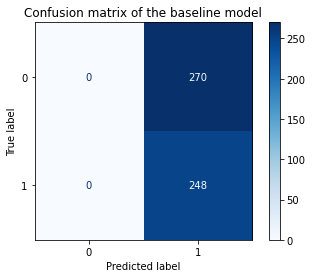

In [11]:
# Plot the confusion matrix of the baseline model
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.asarray([[0,270],[0,248]]))
disp = disp.plot(cmap='Blues')
plt.title('Confusion matrix of the baseline model')
plt.savefig(fname='../img/cm_null.png')
plt.show()


As you can see, the baseline model predicts 248 out of 518 (47.9%) posts correctly. This is not a good accuracy by any means.

### Hypothesis testing  

Now that we have a baseline model, we can formulate a hypothesis test.  

The hypothesis test will use the McNemar's test to compare the accuracy of the baseline model and the trained model.

$H0 : $There is no difference in accuracy between the baseline model and the trained model.  
$ H0 :  \frac{(|B - C| -1)^2} {B + C} = 0$  

$HA : $There is a difference in accuracy between the baseline model and the trained model.  
$ HA : \frac{(|B - C| -1)^2} {B + C} \neq 0$ 

Level of significance: $\alpha = 0.05$

Where B is the number of predictions that the baseline model predicted correctly but the trained model predicted wrongly, and C is the number of predictions that the trained model predicted correctly but the baseline model predicted wrongly.

### Finding the best estimator and parameters  

In order to pick the best estimator and parameters, a custom class will be used to do multiple gridsearches for each estimator and parameter that we specify and produce a dataframe of the min, max, mean scores for the combinations of estimators and parameters.

In [12]:
# Create a dictionary of estimators that we want to check
estimators = {
    'rfc': RandomForestClassifier(),
    'knn': KNeighborsClassifier()
}

In [13]:
# Create a dictionary of parameters for the estimators that we want to check
params = {
    'rfc': {'n_estimators': [50,100,250,500], 'max_depth': [None, 3, 5, 7],'max_features': ['sqrt','log2',1/3], 'random_state': [6]},
    'knn': {'n_neighbors': [2,3,4,5], 'p': [1,2], 'n_jobs': [-1],'weights': ['distance','uniform']}
}

In [14]:
# Instantiate an instance of the EstimatorChecker class with the estimators and parameters.
estimators_check = EstimatorChecker(estimators, params)

# Fit the instance with the transformed X_train and the y_train to train and score the model
estimators_check.fit(X_train_pre, y_train)

Running GridSearchCV for rfc.
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for knn.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.5s finished


In [15]:
# Check the top 5 models in terms of mean_score 
estimators_check.score_summary(sort_by='mean_score')

rfc
knn


,estimator,min_score,mean_score,max_score,std_score,max_depth,max_features,n_estimators,random_state,n_jobs,n_neighbors,p,weights
3,rfc,0.937824,0.954442,0.968912,0.0110961,None,sqrt,500,6,NaN,NaN,NaN,NaN
2,rfc,0.937824,0.9534,0.969072,0.0118576,None,sqrt,250,6,NaN,NaN,NaN,NaN
5,rfc,0.937824,0.951338,0.958763,0.00779507,None,log2,100,6,NaN,NaN,NaN,NaN
1,rfc,0.932642,0.951338,0.958763,0.00964255,None,sqrt,100,6,NaN,NaN,NaN,NaN
6,rfc,0.932642,0.950307,0.963731,0.0101685,None,log2,250,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,knn,0.747423,0.791972,0.813472,0.0250003,NaN,NaN,NaN,NaN,-1,3,1,distance
56,knn,0.747423,0.790935,0.818653,0.025479,NaN,NaN,NaN,NaN,-1,4,1,distance
53,knn,0.742268,0.787832,0.80829,0.0255324,NaN,NaN,NaN,NaN,-1,3,1,uniform
60,knn,0.731959,0.778516,0.80829,0.0264122,NaN,NaN,NaN,NaN,-1,5,1,distance


The model which performed the best was `rfc` with `max_depth=None`, `max_features=sqrt` and `n_estimators=500` with an average accuracy of 0.95442.  

Thus, we will use these parameters for our model.

### Instantiating, fitting, and scoring our model

In [16]:
# Instantiate the RandomForestClassifier with our best parameters
rfc = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt', n_jobs=-1, random_state = 6)

# Fit the model to our training data
rfc.fit(X_train_pre, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=500, n_jobs=-1,
                       random_state=6)

In [17]:
# Check the score of our training data
train_score = rfc.score(X_train_pre, y_train)

# Check the score on our testing data (From the train-test-split)
train_test_score = rfc.score(X_test_pre, y_test)

# Check the score on our new data from the test dataset
test_score = rfc.score(test_X_pre, test_y)

In [18]:
print(f'The accuracy score of the model on the training data is {train_score}.')
print(f'The accuracy score of the model on the training test data is {train_test_score}.')
print(f'The accuracy score of the model on the test data is {test_score}.')

The accuracy score of the model on the training data is 1.0.
The accuracy score of the model on the training test data is 0.9628099173553719.
The accuracy score of the model on the test data is 0.9613899613899614.


The model had a high accuracy of 1.0 on the training data as that is what the model was training on.  
When it came to unseen data from the training test set as well as the actual test data, the model was slightly less accurate, with accuracy of 96% and 97% respectively.  

This is still quite a good result as there is not a large variance of error.  

However, since we are trying to predict if a post is from `TheOnion` based on the features, accuracy is not our best predictor.  

We want a collection of headlines and articles that sound real but are actually satire to use as skits for the Drama club. Hence, we want to minimize the number of false positives, which are posts that were predicted to be from `TheOnion` but were actually `WorldNews`.  

This is because we only want to perform skits which are not based on real events.

In [19]:
# Predict the results of the test set and plot a confusion matrix
y_preds = rfc.predict(test_X_pre)
cm = confusion_matrix(test_y, y_preds)
cm

array([[265,   5],
       [ 15, 233]], dtype=int64)

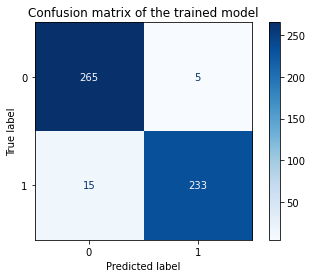

In [20]:
# Visualize the confusion matrix

plot_confusion_matrix(rfc, test_X_pre, test_y, cmap='Blues', values_format='d')
plt.title('Confusion matrix of the trained model')

# Save the plots as an image file.
plt.savefig(fname='../img/cm.png')

Visualizing the confusion matrix, we can see that we have very few false negatives and even fewer false positives, which is good.

In [21]:
# Set the true negative, false positive, false negative, and true positive
tn, fp, fn, tp = cm.ravel()

# Calculate the specificity
spec = tn/(tn+fp)

# Calculate the sensitivity
sens = tp/(tp+fn)

print(f'Accuracy: {rfc.score(test_X_pre, test_y)}')
print(f'Sensitivity: {tp/(tp+fn)}')
print(f'Specificity: {tn/(tn+fp)}')

Accuracy: 0.9613899613899614
Sensitivity: 0.9395161290322581
Specificity: 0.9814814814814815


As we explored above, the confusion matrix of our baseline model was:  
![cm_null](../img/cm_null.png)  
It got 248 correctly and 270 wrongly.
  
Our trained model predicted 498 correctly and 20 wrongly.  

Putting this in a confusion matrix for our McNemar's test, we would get the following:

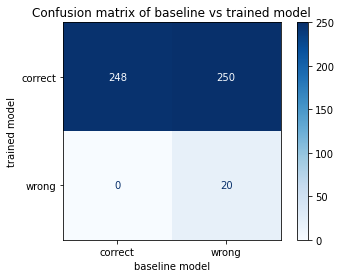

In [22]:
# Plot the confusion matrix of the baseline model

disp = ConfusionMatrixDisplay(confusion_matrix=np.asarray([[248,250],[0,20]]))
disp = disp.plot(cmap='Blues')
plt.title('Confusion matrix of baseline vs trained model')
plt.xlabel('baseline model')
plt.xticks(ticks=[0,1], labels=['correct','wrong'])
plt.ylabel('trained model')
plt.yticks(ticks=[0,1], labels=['correct','wrong'])
plt.savefig(fname='../img/cm_mn.png')
plt.show()

Using this confusion matrix as an array, we can calculate the p-value for our hypothesis test using mcnemar from statsmodels.

In [23]:
# Define contingency table
table = [[248, 250],
        [0, 20]]

# Calculate the McNemar's test
result = mcnemar(table, exact=True)

# Summarize the finding
print(f'p-value={result.pvalue}')

p-value=1.105429575052089e-75


The p-value that we calculated is less than 0.00001. Hence, we can reject the null hypothesis as it is highly improbable that we got these results by chance.

# Conclusion
Our trained model was able to predict the subreddit with a very high specificity of 98%, which outperformed even its accuracy.  
This is great news as a high specificity means that the number of false positives are low, which is what we are looking for.  

The trained model outperformed the baseline model by more than double, and we have rejected the null hypothesis and accepted the alternative hypothesis that there is a difference in accuracy between the baseline model and the trained model.

Hence we can conclude that the model will perform well for our needs, although there is still a small room for improvement if we are seeking a 100% specificity rate.  

The TfidfVectorizer could be run through GridSearch to optimize the parameters, and more data can be collected in order to improve the model. Further, not all `article_text` could be extracted properly, and the data may not be accurate and completed, hence a better `article_text` scraper could be implemented.